`Дифференциал тооцоолол нь машин сургалтын алгоритмын чухал хэрэгсэл юм. Мэдрэлийн сүлжээнүүд, ялангуяа градиент буурах алгоритм нь градиентаас хамаардаг бөгөөд энэ нь дифференциалаар тооцоолсон хэмжигдэхүүн юм.`

1. Total differential and total derivatives

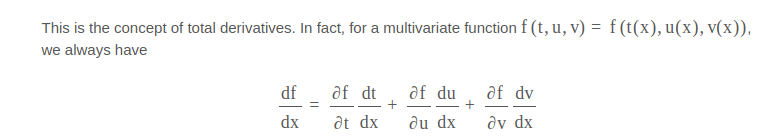

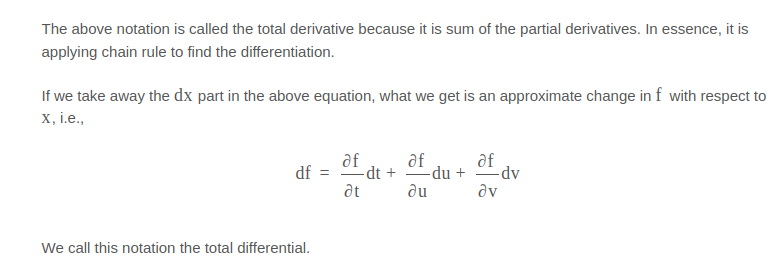

2. Algebraic representation of a multilayer perceptron model

Consider the network:

<img src="https://upload.wikimedia.org/wikipedia/commons/3/30/Multilayer_Neural_Network.png"> 

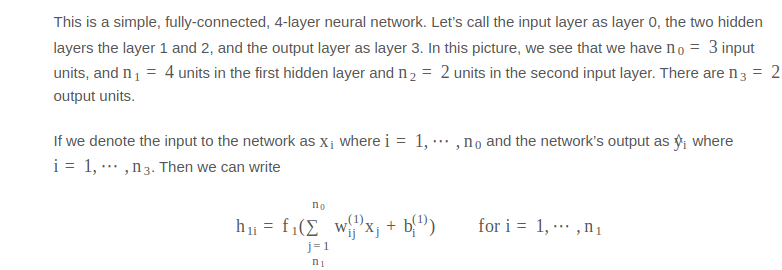

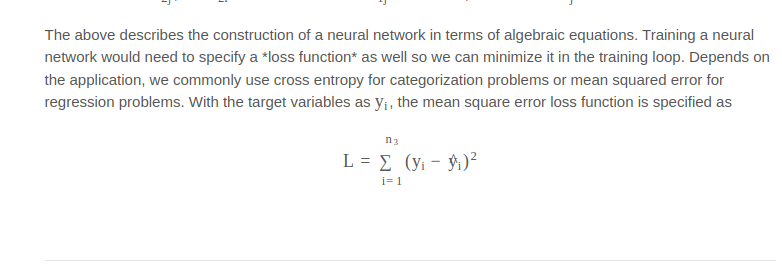

3. Finding the gradient by back-propagation

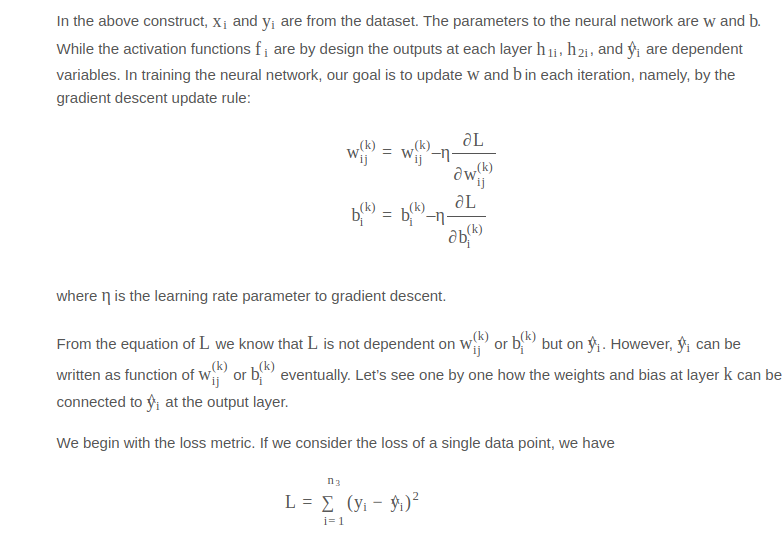

4. Matrix form of gradient equations

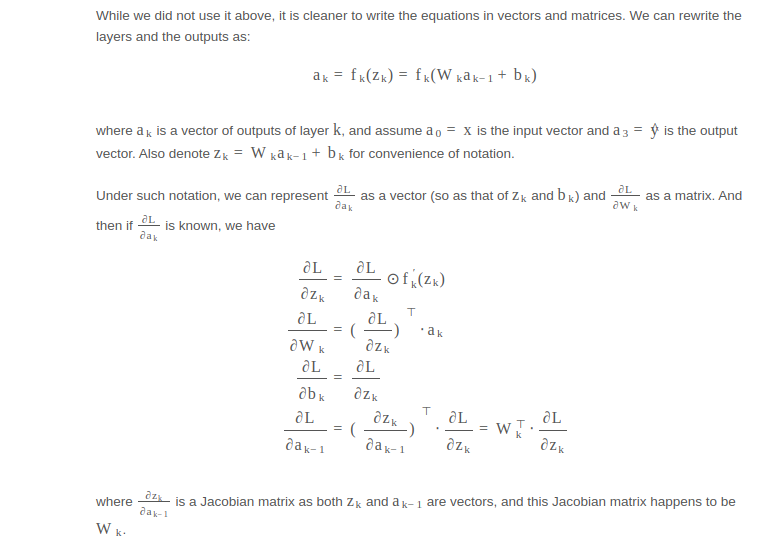

5. Implementing back-propagation

Матрицын тэгшитгэлийн хэлбэр бидэнд хэрэгтэй, учир нь энэ нь бидний кодыг илүү хялбар болгож, олон давталт хийхгү болно. Эдгээр тэгшитгэлийг хэрхэн код болгон хувиргаж, numpy ашиглан эхнээс нь ангилах олон давхаргат перцептрон загварыг хэрхэн хийхийг харцгаая. Хамгийн эхний зүйл бол идэвхжүүлэх функц болон алдагдлын функцийг хэрэгжүүлэх хэрэгтэй. Аль аль нь ялгах функц байх ёстой, эс тэгвээс бидний градиент буурах журам ажиллахгүй. Өнөө үед далд давхаргад ReLU идэвхжүүлэлт, гаралтын давхаргад сигмоид идэвхжүүлэлтийг ашиглах нь түгээмэл болсон. Бид тэдгээрийг функц (оролтыг numpy массив гэж тооцдог) болон ялгах байдлаар тодорхойлдог:



Then we can implement our multilayer perceptron model. To make it easier to read, we want to create the model by providing the number of neurons at each layer as well as the activation function at the layers. But at the same time, we would also need the differentiation of the activation functions as well as the differentiation of the loss function for the training. The loss function itself, however, is not required but useful for us to track the progress. We create a class to ensapsulate the entire model, and define each layer 
 according to the formula:
 
$$\mathbf{a}_k = f_k(\mathbf{z}_k) = f_k(\mathbf{a}_{k-1}\mathbf{W}_k+\mathbf{b}_k)$$

In [13]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score

import numpy as np

# Find a small float to avoid division by zero
epsilon = np.finfo(float).eps

# Sigmoid function and its differentiation
def sigmoid(z):
    return 1/(1+np.exp(-z.clip(-500, 500)))
def dsigmoid(z):
    s = sigmoid(z)
    return 2 * s * (1-s)

# ReLU function and its differentiation
def relu(z):
    return np.maximum(0, z)
def drelu(z):
    return (z > 0).astype(float)

"""
We deliberately clip the input of the sigmoid function to between -500 to +500 to avoid overflow. 
Otherwise, these functions are trivial. Then for classification, we care about accuracy but the accuracy function is not differentiable. 
Therefore, we use the cross entropy function as loss for training:
"""

# Loss function L(y, yhat) and its differentiation
def cross_entropy(y, yhat):
    """Binary cross entropy function
        L = - y log yhat - (1-y) log (1-yhat)

    Args:
        y, yhat (np.array): 1xn matrices which n are the number of data instances
    Returns:
        average cross entropy value of shape 1x1, averaging over the n instances
    """
    return -(y.T @ np.log(yhat.clip(epsilon)) + (1-y.T) @ np.log((1-yhat).clip(epsilon))) / y.shape[1]

def d_cross_entropy(y, yhat):
    """ dL/dyhat """
    return - np.divide(y, yhat.clip(epsilon)) + np.divide(1-y, (1-yhat).clip(epsilon))
    
    """
    Дээр дурдсан зүйлд бид гаралт ба зорилтот хувьсагчдыг numpy дахь мөрийн матриц гэж үзнэ. 
    Тиймээс бид dot product-iig оператор @-г ашиглан нийлбэрийг тооцоолж, гаралтын элементийн тоонд хуваана. 
    Энэхүү загвар нь дээжийн багц дээрх дундаж хөндлөн энтропийг тооцоолоход зориулагдсан гэдгийг анхаарна уу.
    """
    
class mlp:
    '''Multilayer perceptron using numpy'''
    def __init__(self, layersizes, activations, derivatives, lossderiv):
        """remember config, then initialize array to hold NN parameters without init"""
        # hold NN config
        self.layersizes = layersizes
        self.activations = activations
        self.derivatives = derivatives
        self.lossderiv = lossderiv
        # parameters, each is a 2D numpy array
        L = len(self.layersizes)
        self.z = [None] * L
        self.W = [None] * L
        self.b = [None] * L
        self.a = [None] * L
        self.dz = [None] * L
        self.dW = [None] * L
        self.db = [None] * L
        self.da = [None] * L

    def initialize(self, seed=42):
        np.random.seed(seed)
        sigma = 0.1
        for l, (insize, outsize) in enumerate(zip(self.layersizes, self.layersizes[1:]), 1):
            self.W[l] = np.random.randn(insize, outsize) * sigma
            self.b[l] = np.random.randn(1, outsize) * sigma

    def forward(self, x):
        self.a[0] = x
        for l, func in enumerate(self.activations, 1):
            # z = W a + b, with `a` as output from previous layer
            # `W` is of size rxs and `a` the size sxn with n the number of data instances, `z` the size rxn
            # `b` is rx1 and broadcast to each column of `z`
            self.z[l] = (self.a[l-1] @ self.W[l]) + self.b[l]
            # a = g(z), with `a` as output of this layer, of size rxn
            self.a[l] = func(self.z[l])
        return self.a[-1]
    """
    Энэ ангиллын z, W, b, a хувьсагч нь урагш дамжихад зориулагдсан ба 
    dz, dW, db, da хувьсагч нь буцаан тархалтад тооцоолох тус тусын градиент юм. 
    
    Samples бүрийг матрицын мөр хэлбэрээр харуулах ба forward() функцэд жингийн матрицыг давхаргын оролт болгонд баруун тийш үржүүлдэг. 
    Давхарга бүрийн идэвхжүүлэх функц, хэмжээс нь өөр байж болох ч процесс нь ижил байна. Мэдрэлийн сүлжээний оролт х-г forward() функцийн давталтаар гаралт болгон хувиргадаг. 
    Сүлжээний гаралт нь ердөө л сүүлийн давхаргын гаралт юм.
    
    Сүлжээг сургахын тулд бид урагш дамжуулалт бүрийн дараа буцах тархалтыг ажиллуулах хэрэгтэй. 
    Буцах тархалт нь гаралтын давхаргаас эхлээд оролтын давхарга хүртэлх давхарга бүрийн жин ба хазайлтын градиентийг тооцоолох явдал юм. 
    тэгшитгэлийн дагуу буцах тархалтын функцийг дараах байдлаар гүйцэтгэнэ.
    """
    def backward(self, y, yhat):
        # first `da`, at the output
        self.da[-1] = self.lossderiv(y, yhat)
        for l, func in reversed(list(enumerate(self.derivatives, 1))):
            # compute the differentials at this layer
            self.dz[l] = self.da[l] * func(self.z[l])
            self.dW[l] = self.a[l-1].T @ self.dz[l]
            self.db[l] = np.mean(self.dz[l], axis=0, keepdims=True)
            self.da[l-1] = self.dz[l] @ self.W[l].T
      
    def update(self, eta):
        for l in range(1, len(self.W)):
            self.W[l] -= eta * self.dW[l]
            self.b[l] -= eta * self.db[l]
            """
            Энд байгаа цорын ганц ялгаа нь бид db-ийг нэг сургалтын дээжээр биш, харин бүхэл багцаар тооцдог. 
            Алдагдлын функц нь багцын дунджаар хэмжигдсэн хөндлөн энтропи учраас дээжийн дунджийг авч дб-ийг мөн тооцдог. 
            Энд хүртэл бид загвараа дуусгасан. Update() функц нь буцах тархалтаар олсон градиентуудыг W ба b параметрүүдэд градиент буурах шинэчлэлтийн дүрмийг ашиглан зүгээр л ашигладаг. 
            Загвараа туршихын тулд бид scikit-learn-ийг ашиглан ангиллын өгөгдлийн багц үүсгэдэг.
            """
    
# Make data: Two circles on x-y plane as a classification problem
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)
y = y.reshape(-1,1) # our model expects a 2D array of (n_sample, n_dim)

and then we build our model: Input is two-dimensional and output is one dimensional (logistic regression). We make two hidden layers of 4 and 3 neurons respectively:

![](https://machinelearningmastery.com/wp-content/uploads/2021/11/neuralnetwork.png)

In [14]:
# Build a model
model = mlp(layersizes=[2, 4, 3, 1],
            activations=[relu, relu, sigmoid],
            derivatives=[drelu, drelu, dsigmoid],
            lossderiv=d_cross_entropy)
model.initialize()
yhat = model.forward(X)
loss = cross_entropy(y, yhat)
print("Before training - loss value {} accuracy {}".format(loss, accuracy_score(y, (yhat > 0.5))))

Before training - loss value [[693.62954455]] accuracy 0.5


Now we train our network. To make things simple, we perform full-batch gradient descent with fixed learning rate:

In [15]:
# train for each epoch
n_epochs = 150
learning_rate = 0.005
for n in range(n_epochs):
    model.forward(X)
    yhat = model.a[-1]
    model.backward(y, yhat)
    model.update(learning_rate)
    loss = cross_entropy(y, yhat)
    print("Iteration {} - loss value {} accuracy {}".format(n, loss, accuracy_score(y, (yhat > 0.5))))

Iteration 0 - loss value [[693.62954455]] accuracy 0.5
Iteration 1 - loss value [[693.62146459]] accuracy 0.5
Iteration 2 - loss value [[693.6151318]] accuracy 0.5
Iteration 3 - loss value [[693.60982713]] accuracy 0.5
Iteration 4 - loss value [[693.60509681]] accuracy 0.5
Iteration 5 - loss value [[693.60079163]] accuracy 0.5
Iteration 6 - loss value [[693.59684918]] accuracy 0.5
Iteration 7 - loss value [[693.59317686]] accuracy 0.5
Iteration 8 - loss value [[693.58973172]] accuracy 0.5
Iteration 9 - loss value [[693.5864685]] accuracy 0.5
Iteration 10 - loss value [[693.58336407]] accuracy 0.5
Iteration 11 - loss value [[693.58038813]] accuracy 0.5
Iteration 12 - loss value [[693.57753319]] accuracy 0.5
Iteration 13 - loss value [[693.57479259]] accuracy 0.5
Iteration 14 - loss value [[693.57215229]] accuracy 0.5
Iteration 15 - loss value [[693.56959174]] accuracy 0.5
Iteration 16 - loss value [[693.56710202]] accuracy 0.5
Iteration 17 - loss value [[693.56467382]] accuracy 0.5
Iter

Хэдийгээр төгс биш ч гэсэн бид бэлтгэл сургуулилтаар сайжирч байгааг харж байна. Наад зах нь дээрх жишээн дээр бид 145-р давталт дээр 80% -иас дээш нарийвчлалтай байгааг харж болно, гэхдээ дараа нь бид загвар нь зөрүүтэй байгааг харсан. Үүнийг бидний дээр хэрэгжүүлээгүй сургалтын хурдыг бууруулснаар сайжруулж болно. Гэсэн хэдий ч энэ нь бид градиентийг буцаан тархалт болон гинжин дүрмээр хэрхэн тооцдог болохыг харуулж байна.